In [2]:
import datetime
import os
import glob
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.backends.backend_pdf import PdfPages
import random
import shutil
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import confusion_matrix

In [3]:
#今日の日付(YY/MM/DD)を定義
today = datetime.date.today()
today = today.strftime("%Y%m%d")

#study_nameを定義
study_name = "paper_prep_biobank_sample"

static_lst = ['date', 'target', 'name', 'role', 'std_concentration', 'abs_value_0', 'abs_value_1', 'abs_value_2']
statics_lst_2 = ["date", 'target', 'role', 'std_concentration', 'diff_0_1', 'diff_1_2', 'diff_2_0']

#日付でフォルダを作成
os.makedirs(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}", exist_ok=True)

In [4]:
info_cols = ['pjpatientID', 'collection_date', 'delivery_date', 'age', 'height', 'weight', 'smoking_history', 'smoking_perday', 'alcohol', 'alcohol_frequency', 'alcohol_perday', 'stage_L1', 'gender', 'ethnicity', 'diseaseJP', 'diseaseENshort',"country", "race"]

df_bio_all_info = pd.read_csv(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/BIO001_integration_sheet_241002.csv")
df_omy_all_info = pd.read_csv(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/OMY001_integration_sheet_241009.csv")

df_concat_info =pd.concat([df_bio_all_info,df_omy_all_info])

#info_colsに整理する
sample_info = df_concat_info[info_cols]

In [25]:
df_all_cancer_min = pd.read_csv(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/sample_data_241025.csv")

In [26]:
df_all_cancer_min

,code_clinical,diseaseENshort,DiAcSpm,creatinine,DiAcSpm/Cre,class,age,stage_L1,gender,data,pj,height,weight,collection_date,country,race,ethnicity
0,BIO001_00386A,Non-cancer,821.567717,201.138056,408.459609,Non-cancer,39,non,Female,new,BIO001,173.0,67.0,2016/11/17,USA,Caucasian,NaN
1,BIO001_21046A,Pancreas,295.790657,20.559742,1438.688590,Cancer,55,II,Female,new,BIO001,165.0,69.0,2019/9/20,Ukraine,Caucasian,NaN
2,BIO001_21037A,Endometrial,215.990613,49.699364,434.594317,Cancer,68,I,Female,new,BIO001,157.0,77.0,2019/3/28,Ukraine,Caucasian,NaN
3,BIO001_21033A,Endometrial,445.702216,152.497551,292.268441,Cancer,78,II,Female,new,BIO001,164.0,85.0,2019/3/21,Ukraine,Caucasian,NaN
4,BIO001_21029A,Pancreas,178.621946,34.787837,513.460911,Cancer,52,IV,Female,new,BIO001,158.0,64.0,2019/4/28,Ukraine,Caucasian,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,BIO001_06190A,Endometrial,278.078891,160.762296,172.975192,Cancer,72,I,Female,new,BIO001,156.0,70.0,2020/2/14,Ukraine,Caucasian,NaN
490,BIO001_20690A,Breast,219.651492,55.099731,398.643491,Cancer,54,II,Female,old,BIO001,170.0,75.0,2019/3/5,Ukraine,Caucasian,NaN
491,BIO001_20735A,Breast,248.975034,117.088697,212.637974,Cancer,47,III,Female,old,BIO001,170.0,70.0,2019/3/6,Ukraine,Caucasian,NaN
492,BIO001_21192A,Breast,310.372088,173.730372,178.651599,Cancer,46,II,Female,old,BIO001,NaN,68.0,2019/3/13,Ukraine,Caucasian,NaN


## 3種類のがんと非がん

In [6]:
cancer_lst = ['Stomach', 'Colorectal', 'Pancreas']
minimum_cols = ['code_clinical', 'diseaseENshort','DiAcSpm', 'creatinine', 'DiAcSpm/Cre', "class",'age', 'stage_L1', 'gender',"pj","country", "race","ethnicity",'height', 'weight',  'collection_date']

#lstのものを抽出
df_all_cancer = df_all_cancer_min[df_all_cancer_min['diseaseENshort'].isin(cancer_lst)]
df_non_cancer = df_all_cancer_min[df_all_cancer_min['diseaseENshort']== "Non-cancer"]

df_all_concat = pd.concat([df_all_cancer, df_non_cancer])

#minimum_colsに整理する
df_merge_all_min = df_all_concat[minimum_cols]

#countryがNaNでpjがbio001のものにはUkrainaを入力 <--元シートを確認済み
df_merge_all_min.loc[(df_merge_all_min['country'].isnull()) & (df_merge_all_min['pj'] == "BIO001"), 'country'] = "Ukraine"
#countryがNaNでpjがomy001のものにはJapanを入力
df_merge_all_min.loc[(df_merge_all_min['country'].isnull()) & (df_merge_all_min['pj'] == "OMY001"), 'country'] = "Japan"
#raceがNaNでpjがomy001のものにはAsiaを入力
df_merge_all_min.loc[(df_merge_all_min['race'].isnull()) & (df_merge_all_min['pj'] == "OMY001"), 'race'] = "Asia"

#code_clinicalが重複しているものを除外
df_merge_all_min = df_merge_all_min.drop_duplicates(subset='code_clinical', keep='first')

In [9]:
#"class"でソート
df_merge_all_min = df_merge_all_min.sort_values(['class',"DiAcSpm/Cre"],ascending=[False,True])

with PdfPages(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/Fig1_Box_all_cancer_{today}.pdf") as pdf:
    # Boxplotの色を指定
    colors = ["#8f8f8f", "#315ab9"]  # 好みの色を指定

    #図のサイズを指定
    #sns.set(style="white")
    plt.figure(figsize=(3, 5))
    sns.boxplot(data=df_merge_all_min, x='class', y='DiAcSpm/Cre', showfliers=False, legend=True, palette=colors)
    #sns.stripplot(data=df_merge_all_min, x='class', y='DiAcSpm/Cre', alpha=0.5, color='gray')
    
    #データ数を図中に表示
    #for i in range(len(df_merge_all_min['class'].unique())):
    #    plt.text(i, 2350, f"n={len(df_merge_all_min[df_merge_all_min['class'] == df_merge_all_min['class'].unique()[i]])}", fontsize=10, ha='center', color='gray', alpha=0.5)

    #タイトル
    plt.title('DiAcSpm/Cre')
    #Y軸を0-3500に固定
    plt.ylim(0,1500)    
    
    #レジェンドを枠の外に
    #plt.legend(bbox_to_anchor=(0.85, 0.98), loc='upper left', borderaxespad=0)
    #サイズを最適化
    plt.tight_layout()
    # PDFへの保存
    pdf.savefig()
    # フィギュアのクローズ
    plt.close()

/var/folders/58/bb06wfv13tjg4lp3d6c19vxc0000gn/T/ipykernel_9566/617160464.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merge_all_min, x='class', y='DiAcSpm/Cre', showfliers=False, legend=True, palette=colors)


In [10]:
# Function to calculate Youden's index and corresponding sensitivity and specificity
def calculate_youden_index(fpr, tpr, thresholds):
    youden_index = tpr - fpr
    max_index = youden_index.argmax()
    best_threshold = thresholds[max_index]
    sensitivity = tpr[max_index]
    specificity = 1 - fpr[max_index]
    return best_threshold, sensitivity, specificity

# Create binary classification based on 'class' column: 1 for 'Cancer', 0 for 'Non-cancer'
df_merge_all_min['class_binary'] = df_merge_all_min['class'].apply(lambda x: 1 if x == 'Cancer' else 0)

# Prepare true labels and predicted scores for males (cancer vs healthy)
y_true = df_merge_all_min['class_binary']
y_scores = df_merge_all_min['DiAcSpm/Cre']

# Compute ROC curve and AUC for male and female (Cancer vs Healthy)
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc_male = auc(fpr, tpr)

# Recalculate Youden's index for male and female
best_threshold, sensitivity, specificity = calculate_youden_index(fpr, tpr, _)

with PdfPages(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/Fig1_ROC(youden)_all_cancer_{today}.pdf") as pdf:
    # Plot ROC curves with Youden's index points
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc_male:.2f}',color="#315ab9") 
    
    # Plot random guess line
    #plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    
    # Mark the Youden's index points on the ROC curves
    plt.scatter([1 - specificity], [sensitivity], marker='o', label=f'Sens: {sensitivity:.2f}, Spec: {specificity:.2f}',color="#315ab9")
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-specificity')
    plt.ylabel('Sensitivity')
    plt.title('ROC Curve for Cancer vs Healthy')
    plt.legend(loc='lower right')

    #サイズを最適化
    #plt.tight_layout()
    # PDFへの保存
    pdf.savefig()
    # フィギュアのクローズ
    plt.close()

In [11]:
# Define the list of specific cancer types and stages for comparison
cancer_lst = ['Colorectal','Stomach','Pancreas']
stage_cat = ["non", "I", "II", "III", "IV"]

# Define color map for stages
stage_palette = {"non": '#8f8f8f', "I": '#315ab9', "II": '#c97c23', "III": '#a1a100', "IV": '#c7306b'}


# List of cancer types and stage categories should be predefined (cancer_lst and stage_cat)
with PdfPages(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/Fig2_Box_all_cancer_stage_{today}.pdf") as pdf:
    # Loop through all cancer types and plot the comparison with Non-cancer
        df_concat = df_merge_all_min
        
        # Sort the stages in the specified order
        df_concat['stage_L1'] = pd.Categorical(df_concat['stage_L1'], categories=stage_cat, ordered=True)
        
        # Define the order to have Non-cancer on the left and the specific cancer on the right
        diseases_present = ['Non-cancer', "Cancer"]
    
        # Plotting the boxplot and stripplot
        plt.figure(figsize=(8, 6))
        sns.boxplot(data=df_concat, x='stage_L1', y='DiAcSpm/Cre', hue='stage_L1', showfliers=False, palette=stage_palette)
        #sns.stripplot(data=df_concat, x='stage_L1', y='DiAcSpm/Cre', color='gray', alpha=0.5, dodge=True, legend=False)

        # Update the legend with filtered entries
        plt.legend(diseases_present, title='Class', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
        
        # Fixing the Y-axis range
        plt.ylim(0, 2000)
        plt.title(f'DiAcSpm/Cre')
        plt.ylabel('DiAcSpm/Cre')
        plt.xlabel('stage')
        plt.tight_layout()

        # Save to PDF
        pdf.savefig()
        plt.close()

In [12]:
with PdfPages(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/ex_ROC(youden)_each_cancer_{today}.pdf") as pdf:
    cancer_types = df_merge_all_min['diseaseENshort'].unique()
        
    # Set up subplots for each cancer type
    fig, axes = plt.subplots(len(cancer_types), 1, figsize=(6, 6 * len(cancer_types)))
    if len(cancer_types) == 1:
        axes = [axes]  # To handle the case with one subplot
    
    for i, cancer_type in enumerate(cancer_types):
        ax = axes[i]
        subset = df_merge_all_min[df_merge_all_min['diseaseENshort'].isin([cancer_type, 'Non-cancer'])]
        
        y_true = subset['class_binary']
        y_scores = subset['DiAcSpm/Cre']
        
        if y_true.nunique() < 2:
            continue  # Skip if there's not both classes present
        
        # Compute ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        
        # Calculate Youden's index
        best_threshold, sensitivity, specificity = calculate_youden_index(fpr, tpr, thresholds)
        
        # Plot ROC curve
        ax.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f}', color="#315ab9")
        
        # Plot the Youden's index point
        ax.scatter([1 - specificity], [sensitivity], marker='o',
                   label=f'Sens: {sensitivity:.2f}, Spec: {specificity:.2f}', color="#315ab9") 
        
        # ax.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line

        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('1-specificity')
        ax.set_ylabel('Sensitivity')

        ax.set_title(f'ROC Curve - {cancer_type}')
        ax.legend(loc="lower right")
    
    # Optimize layout
    plt.tight_layout()
    # Save to PDF
    pdf.savefig()
    # Close the figure
    plt.close()

In [13]:
with PdfPages(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/Fig2_ROC(youden)_all_cancer_stage_{today}.pdf") as pdf:
    # Create binary classification based on 'class' column: 1 for 'Cancer', 0 for 'Non-cancer'
    df_merge_all_min['class_binary'] = df_merge_all_min['class'].apply(lambda x: 1 if x == 'Cancer' else 0)
    
    # Create subplots: Adjust dimensions if necessary
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))  # One plot for all stages
    
    for stage in ["I", "II", "III", "IV"]: 
        # Filter data for the current stage
        subset = df_merge_all_min
        cancer_data_stage = subset[(subset['stage_L1'] == stage)]
        control_data = subset[(subset['diseaseENshort'] == "Non-cancer")]
        
        # Concatenate cancer data with control data
        combined_data = pd.concat([cancer_data_stage, control_data])
        
        # Prepare true labels and predicted scores
        y_true = combined_data['class_binary']  # Binary labels: 1 for Cancer, 0 for Healthy
        y_scores = combined_data['DiAcSpm/Cre']  # Use DiAcSpm/Cre ratio as the score
        
        # Compute ROC curve and AUC for the current stage
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve for the current stage
        ax.plot(fpr, tpr, color=stage_palette[stage], lw=2, label=f'Stage {stage} (AUC = {roc_auc:.2f})')
        
        # Recalculate Youden's index
        best_threshold, sensitivity, specificity = calculate_youden_index(fpr, tpr, _)
        
        # Mark the Youden's index points on the ROC curves
        ax.scatter([1 - specificity], [sensitivity], color=stage_palette[stage], marker='o', label=f'Sens: {sensitivity:.2f}, Spec: {specificity:.2f}')
    
    # Add random guess line and labels
    #ax.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random guess line
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_xlabel('1-specificity')
    ax.set_ylabel('Sensitivity')
    
    ax.set_title('ROC Curve by Stage')
    ax.legend(loc='lower right')
    
    # Optimize layout
    plt.tight_layout()
    
    # Save to PDF
    pdf.savefig(fig)
    plt.close(fig)

In [15]:
# Define the list of specific cancer types and stages for comparison
cancer_lst = ['Colorectal','Stomach', 'Pancreas']
stage_cat = ["non", "I", "II", "III", "IV"]

# Define color map for stages
stage_palette = {"non": '#8f8f8f', "I": '#315ab9', "II": '#c97c23', "III": '#a1a100', "IV": '#c7306b'}

# List of cancer types and stage categories should be predefined (cancer_lst and stage_cat)
with PdfPages(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/Fig3_Box_each_cancer_stage_{today}.pdf") as pdf:
    # Loop through all cancer types and plot the comparison with Non-cancer
    for cancer in cancer_lst:
        # Filter data for specific cancer and Non-cancer
        df_case = df_merge_all_min[df_merge_all_min['diseaseENshort'] == cancer]
        df_control = df_merge_all_min[df_merge_all_min['diseaseENshort'] == 'Non-cancer']
        df_concat = pd.concat([df_case, df_control])
    
        # Sort the stages in the specified order
        df_concat['stage_L1'] = pd.Categorical(df_concat['stage_L1'], categories=stage_cat, ordered=True)
        
        # Define the order to have Non-cancer on the left and the specific cancer on the right
        diseases_present = ['Non-cancer', cancer]
    
        # Plotting the boxplot and stripplot
        plt.figure(figsize=(8, 6))
        sns.boxplot(data=df_concat, x='stage_L1', y='DiAcSpm/Cre', hue='stage_L1', showfliers=False, palette=stage_palette)
        #sns.stripplot(data=df_concat, x='stage_L1', y='DiAcSpm/Cre', color='gray', alpha=0.5, dodge=True, legend=False )
                # Update the legend with filtered entries
        plt.legend(diseases_present, title='disease', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
        
        # Fixing the Y-axis range
        plt.ylim(0, 1500)
        plt.title(f'DiAcSpm/Cre in {cancer}')
        plt.ylabel('DiAcSpm/Cre')
        plt.xlabel('stage')
        plt.tight_layout()

        # Save to PDF
        pdf.savefig()
        plt.close()

In [16]:
# Assuming calculate_youden_index function is already defined somewhere in your code
with PdfPages(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/Fig3_ROC(youden)_stage_{today}.pdf") as pdf:
    # Create binary classification based on 'class' column: 1 for 'Cancer', 0 for 'Non-cancer'
    df_merge_all_min['class_binary'] = df_merge_all_min['class'].apply(lambda x: 1 if x == 'Cancer' else 0)
   
    # Create subplots: 3 rows (for 3 cancer types)
    fig, axes = plt.subplots(len(cancer_lst), 1, figsize=(7, 20), sharey=True)
    
    for i, cancer_type in enumerate(cancer_lst):
        subset = df_merge_all_min[df_merge_all_min['diseaseENshort'].isin([cancer_type, 'Non-cancer'])]
        ax = axes[i]
        
        for stage in ["I", "II", "III", "IV"]: 
            # Filter data for the current stage
            cancer_data_stage = subset[(subset['stage_L1'] == stage)]
            control_data = subset[(subset['diseaseENshort'] == "Non-cancer")]
            
            # Concatenate cancer data with control data
            combined_data = pd.concat([cancer_data_stage, control_data])
            
            # Prepare true labels and predicted scores
            y_true = combined_data['class_binary']  # Binary labels: 1 for Cancer, 0 for Healthy
            y_scores = combined_data['DiAcSpm/Cre']  # Use DiAcSpm/Cre ratio as the score
            
            # Compute ROC curve and AUC for the current stage
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)
            
            # Plot ROC curve for the current stage
            ax.plot(fpr, tpr, color=stage_palette[stage], lw=2, label=f'Stage {stage} (AUC = {roc_auc:.2f})')
            
            # Recalculate Youden's index
            best_threshold, sensitivity, specificity = calculate_youden_index(fpr, tpr, _)
            
            # Mark the Youden's index points on the ROC curves
            ax.scatter([1 - specificity], [sensitivity], color=stage_palette[stage], marker='o', label=f'Sens: {sensitivity:.2f}, Spec: {specificity:.2f}')
        
        # Add random guess line and labels
        #ax.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random guess line
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve - {cancer_type}')
        ax.legend(loc='lower right')
    
    # Optimize layout
    plt.tight_layout()
    
    # Save to PDF or display plot
    pdf.savefig()
    plt.close()

In [17]:
#"class"でソート
df_merge_all_min = df_merge_all_min.sort_values(['class',"DiAcSpm/Cre"],ascending=[False,True])

# Colorectal, Stomach, Pancreasの順で表示
cancer_lst = ["Non-cancer",'Colorectal', 'Stomach', 'Pancreas']
df_merge_all_min['diseaseENshort'] = pd.Categorical(df_merge_all_min['diseaseENshort'], categories=cancer_lst, ordered=True)

with PdfPages(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/ex_Box_each_cancer_{today}.pdf") as pdf:
    #図のサイズを指定
    plt.figure(figsize=(6, 6))
    sns.boxplot(data=df_merge_all_min, x='diseaseENshort', y='DiAcSpm/Cre', showfliers=False, hue="class", legend=True)
    sns.stripplot(data=df_merge_all_min, x='diseaseENshort', y='DiAcSpm/Cre', color="gray", alpha=0.5, dodge=True)
    
    #データ数を図中に表示
    for i in range(len(df_merge_all_min['diseaseENshort'].unique())):
        plt.text(i, 2000, f"n={len(df_merge_all_min[df_merge_all_min['diseaseENshort'] == df_merge_all_min['diseaseENshort'].unique()[i]])}", fontsize=10, ha='center', color='gray', alpha=0.5)

    #タイトル
    plt.title('DiAcSpm/Cre')
    #Y軸を0-3500に固定
    plt.ylim(0,2500)    
    
    #レジェンドを枠の外に
    plt.legend(bbox_to_anchor=(0.7, 0.98), loc='upper left', borderaxespad=0)
    
    #X軸のタイトル
    plt.xlabel('disease')
    
    #サイズを最適化
    plt.tight_layout()
    # PDFへの保存
    pdf.savefig()
    # フィギュアのクローズ
    plt.close()

In [18]:
with PdfPages(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/Fig4_Box_bio_omy_comparison_{today}.pdf") as pdf:
    order_lst = ["BIO001", "OMY001"]
    class_lst = ["Non-cancer", "Cancer"]
    
    # データをorder_lstの順に並び替え
    df_merge_all_min['pj'] = pd.Categorical(df_merge_all_min['pj'], categories=order_lst, ordered=True)
    
    # genderでソート
    df_merge_all_min = df_merge_all_min.sort_values(['class'], ascending=[False])
    
    # Boxplotの色を指定
    colors = ["#8f8f8f", "#c97c23"]  # 好みの色を指定
    
    plt.figure(figsize=(6, 8))
    sns.boxplot(hue='pj', y='DiAcSpm/Cre', data=df_merge_all_min, x="class", showfliers=False, palette=colors)
    
    sns.stripplot(data=df_merge_all_min, hue='pj', y='DiAcSpm/Cre', x="class", color="gray", alpha=0.3, dodge=True, legend=False)
    
    # BOXplotの中央にorder_lstの順にデータ数を表示
    for i in range(len(class_lst)):
        plt.text(i, 2200, f"n={len(df_merge_all_min[df_merge_all_min['class'] == class_lst[i]])}", fontsize=10, ha='center', color='gray', alpha=0.5)
    
    # レジェンドを枠の外に
    plt.legend(bbox_to_anchor=(0.78, 0.98), loc='upper left', borderaxespad=0)
    
    # Y軸を0-250に固定
    plt.ylim(0, 2500)
    plt.title('DiAcSpm/Cre')
    plt.xlabel('Cohort')
    plt.ylabel('DiAcSpm/Cre')
    
    # サイズを最適化
    plt.tight_layout()
    
    # PDFへの保存
    pdf.savefig()
    # フィギュアのクローズ
    plt.close()


/var/folders/58/bb06wfv13tjg4lp3d6c19vxc0000gn/T/ipykernel_9566/3985899051.py:17: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:gray'` for the same effect.

  sns.stripplot(data=df_merge_all_min, hue='pj', y='DiAcSpm/Cre', x="class", color="gray", alpha=0.3, dodge=True, legend=False)


In [118]:
from scipy.stats import ttest_ind

# Filter data for Non-cancer patients and separate by gender
non_cancer_data = df_merge_all_min[df_merge_all_min['diseaseENshort'] == 'Non-cancer']
male_data_spm = non_cancer_data[non_cancer_data['gender'] == 'Male']['DiAcSpm']
female_data_spm = non_cancer_data[non_cancer_data['gender'] == 'Female']['DiAcSpm']

# Perform an independent t-test to compare DiAcSpm levels between males and females
t_stat_spm, p_value_spm = ttest_ind(male_data_spm.dropna(), female_data_spm.dropna())
t_stat_spm, p_value_spm

(0.5240517644346101, 0.6017675565918804)

In [119]:
# Filter data for Non-cancer patients and separate by gender
non_cancer_data = df_merge_all_min[df_merge_all_min['diseaseENshort'] == 'Non-cancer']
male_data_spm_cre = non_cancer_data[non_cancer_data['gender'] == 'Male']['DiAcSpm/Cre']
female_data_spm_cre = non_cancer_data[non_cancer_data['gender'] == 'Female']['DiAcSpm/Cre']

# Perform an independent t-test to compare DiAcSpm levels between males and females
t_stat_spm_cre, p_value_spm_cre = ttest_ind(male_data_spm_cre.dropna(), female_data_spm_cre.dropna())
t_stat_spm_cre, p_value_spm_cre

(0.6322081833626486, 0.5291482089882151)

In [120]:
from scipy.stats import mannwhitneyu

# Filter for Non-cancer data and separate by gender
non_cancer_data = df_merge_all_min[df_merge_all_min['diseaseENshort'] == 'Non-cancer']
male_data = non_cancer_data[non_cancer_data['gender'] == 'Male']
female_data = non_cancer_data[non_cancer_data['gender'] == 'Female']

# Extract DiAcSpm and DiAcSpm/Cre for both genders
male_di_ac_spm = male_data['DiAcSpm'].dropna()
female_di_ac_spm = female_data['DiAcSpm'].dropna()
male_di_ac_spm_cre = male_data['DiAcSpm/Cre'].dropna()
female_di_ac_spm_cre = female_data['DiAcSpm/Cre'].dropna()

# Perform Mann-Whitney U test for DiAcSpm
u_statistic_di_ac_spm, p_value_mwu_di_ac_spm = mannwhitneyu(male_di_ac_spm, female_di_ac_spm, alternative='two-sided')

# Perform Mann-Whitney U test for DiAcSpm/Cre
u_statistic_di_ac_spm_cre, p_value_mwu_di_ac_spm_cre = mannwhitneyu(male_di_ac_spm_cre, female_di_ac_spm_cre, alternative='two-sided')

# Output results
(u_statistic_di_ac_spm, p_value_mwu_di_ac_spm), (u_statistic_di_ac_spm_cre, p_value_mwu_di_ac_spm_cre)


((675.0, 0.43918518851335697), (414.0, 0.000684607475520311))

In [122]:
from scipy.stats import mannwhitneyu

# Filter for Non-cancer data and separate by gender
cancer_data = df_merge_all_min[df_merge_all_min['class'] == 'Cancer']
male_cancer_data = cancer_data[cancer_data['gender'] == 'Male']
female_cancer_data = cancer_data[cancer_data['gender'] == 'Female']

# Extract DiAcSpm and DiAcSpm/Cre for both genders
male_cancer_di_ac_spm = male_cancer_data['DiAcSpm'].dropna()
female_cancer_di_ac_spm = female_cancer_data['DiAcSpm'].dropna()
male_cancer_di_ac_spm_cre = male_cancer_data['DiAcSpm/Cre'].dropna()
female_cancer_di_ac_spm_cre = female_cancer_data['DiAcSpm/Cre'].dropna()

# Perform Mann-Whitney U test for DiAcSpm
u_statistic_di_ac_spm_cancer, p_value_mwu_di_ac_spm_cancer = mannwhitneyu(male_cancer_di_ac_spm, female_cancer_di_ac_spm, alternative='two-sided')

# Perform Mann-Whitney U test for DiAcSpm/Cre
u_statistic_di_ac_spm_cre_cancer, p_value_mwu_di_ac_spm_cre_cancer = mannwhitneyu(male_cancer_di_ac_spm_cre, female_cancer_di_ac_spm_cre, alternative='two-sided')

# Output results
(u_statistic_di_ac_spm_cancer, p_value_mwu_di_ac_spm_cancer), (u_statistic_di_ac_spm_cre_cancer, p_value_mwu_di_ac_spm_cre_cancer)


((2353.0, 0.04791500006033976), (2101.0, 0.4632774365240968))

In [ ]:
from scipy.stats import chi2_contingency

# Filter for relevant cancer types and stages
selected_cancers = ['Stomach', 'Colorectal', 'Pancreas']
filtered_data = df_merge_all_min[df_merge_all_min['diseaseENshort'].isin(selected_cancers + ['Non-cancer'])]

# Create a contingency table for counts of each stage within the selected cancer types and Non-cancer
contingency_table = pd.crosstab(filtered_data['diseaseENshort'], filtered_data['stage_L1'])

# Perform Chi-squared test to check for association between cancer type and stage distribution
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Display the contingency table, Chi-squared statistic, and p-value
contingency_table, chi2_stat, p_value


In [ ]:
# Create contingency tables and perform Chi-squared tests for gender distribution comparing Non-cancer with each cancer type individually

# Initialize a dictionary to store results for each comparison
comparison_results = {}

# Cancer types to compare with Non-cancer
cancer_types = ['Colorectal', 'Pancreas', 'Stomach']

# Perform Chi-squared test for gender distribution between Non-cancer and each cancer type
for cancer_type in cancer_types:
    # Filter data for Non-cancer and the specific cancer type
    comparison_data = filtered_data[filtered_data['diseaseENshort'].isin(['Non-cancer', cancer_type])]
    
    # Create contingency table
    contingency_table = pd.crosstab(comparison_data['diseaseENshort'], comparison_data['gender'])
    
    # Perform Chi-squared test
    chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)
    
    # Store the result
    comparison_results[cancer_type] = {'chi2_stat': chi2_stat, 'p_value': p_value, 'contingency_table': contingency_table}
comparison_results

In [ ]:
# Create binary classification based on 'class' column: 1 for 'Cancer', 0 for 'Non-cancer'
df_merge_all_min['class_binary'] = df_merge_all_min['class'].apply(lambda x: 1 if x == 'Cancer' else 0)

# Filter data for male and female
male_data = df_merge_all_min[df_merge_all_min['gender'] == 'Male']
female_data = df_merge_all_min[df_merge_all_min['gender'] == 'Female']

# Filter data for Cancer and Non-cancer (healthy) for male and female
male_cancer = male_data[male_data['class'] == 'Cancer']
male_healthy = male_data[male_data['class'] == 'Non-cancer']

female_cancer = female_data[female_data['class'] == 'Cancer']
female_healthy = female_data[female_data['class'] == 'Non-cancer']

# Prepare true labels and predicted scores for males (cancer vs healthy)
y_true_male = male_data['class_binary']  # Binary labels: 1 for Cancer, 0 for Healthy
y_scores_male = male_data['DiAcSpm/Cre']  # Use DiAcSpm/Cre ratio as the score

# Prepare true labels and predicted scores for females (cancer vs healthy)
y_true_female = female_data['class_binary']
y_scores_female = female_data['DiAcSpm/Cre']

# Compute ROC curve and AUC for male and female (Cancer vs Healthy)
fpr_male, tpr_male, _ = roc_curve(y_true_male, y_scores_male)
roc_auc_male = auc(fpr_male, tpr_male)

fpr_female, tpr_female, _ = roc_curve(y_true_female, y_scores_female)
roc_auc_female = auc(fpr_female, tpr_female)

# Fixing the unpacking issue, should include the third return value (thresholds) for both male and female
fpr_male, tpr_male, thresholds_male = roc_curve(y_true_male, y_scores_male)
fpr_female, tpr_female, thresholds_female = roc_curve(y_true_female, y_scores_female)

# Recalculate Youden's index for male and female
best_threshold_male, sensitivity_male, specificity_male = calculate_youden_index(fpr_male, tpr_male, thresholds_male)
best_threshold_female, sensitivity_female, specificity_female = calculate_youden_index(fpr_female, tpr_female, thresholds_female)

with PdfPages(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/ROC(youden)_gender_{today}.pdf") as pdf:
    # Plot ROC curves with Youden's index points
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_male, tpr_male, color='blue', lw=2, label=f'Male (AUC = {roc_auc_male:.2f})')
    plt.plot(fpr_female, tpr_female, color='red', lw=2, label=f'Female (AUC = {roc_auc_female:.2f})')
    
    # Plot random guess line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    
    # Mark the Youden's index points on the ROC curves
    plt.scatter([1 - specificity_male], [sensitivity_male], color='blue', marker='o', label=f'Male Sens: {sensitivity_male:.2f}, Spec: {specificity_male:.2f}')
    plt.scatter([1 - specificity_female], [sensitivity_female], color='red', marker='o', label=f'Female Sens: {sensitivity_female:.2f}, Spec: {specificity_female:.2f}')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Cancer vs Healthy')
    plt.legend(loc='lower right')
    
        #レジェンドを枠の外に
    #plt.legend(bbox_to_anchor=(0.85, 0.98), loc='upper left', borderaxespad=0)
    #サイズを最適化
    plt.tight_layout()
    # PDFへの保存
    pdf.savefig()
    # フィギュアのクローズ
    plt.close()

#optimal_idx_male = np.argmax(best_threshold_male)
#optimal_idx_female = np.argmax(best_threshold_male)
# 最適しきい値を出力
print(f'Youden Indexが最大となるDiAcSpm/Creの濃度は: {best_threshold_male:.2f}')
print(f'Youden Indexが最大となるDiAcSpm/Creの濃度は: {best_threshold_female:.2f}')

In [ ]:
with PdfPages(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/ROC(youden)_each_cancer_gender_{today}.pdf") as pdf:
    cancer_types = df_merge_all_min['diseaseENshort'].unique()
    gender_colors = {'Male': '#5B9BD5', 'Female': '#D5695B'}
    
    # Set up subplots for each cancer type
    fig, axes = plt.subplots(len(cancer_types), 1, figsize=(8, 6 * len(cancer_types)))
    if len(cancer_types) == 1:
        axes = [axes]  # To handle the case with one subplot
    
    for i, cancer_type in enumerate(cancer_types):
        ax = axes[i]
        subset = df_merge_all_min[df_merge_all_min['diseaseENshort'].isin([cancer_type, 'Non-cancer'])]
        
        for gender in gender_colors:
            gender_data = subset[subset['gender'] == gender]
            y_true = gender_data['class_binary']
            y_scores = gender_data['DiAcSpm/Cre']
            
            if y_true.nunique() < 2:
                continue  # Skip if there's not both classes present
            
            # Compute ROC curve
            fpr, tpr, thresholds = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)
            
            # Calculate Youden's index
            best_threshold, sensitivity, specificity = calculate_youden_index(fpr, tpr, thresholds)
            
            # Plot ROC curve
            ax.plot(fpr, tpr, color=gender_colors[gender], lw=2, label=f'{gender} (AUC = {roc_auc:.2f})')
            
            # Plot the Youden's index point
            ax.scatter([1 - specificity], [sensitivity], color=gender_colors[gender], marker='o',
                       label=f'{gender} Sens: {sensitivity:.2f}, Spec: {specificity:.2f}, cutoff: {best_threshold:.2f} nM/g Cre')
        
        ax.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve - {cancer_type}')
        ax.legend(loc="lower right")
    
    #サイズを最適化
    plt.tight_layout()
    # PDFへの保存
    pdf.savefig()
    # フィギュアのクローズ
    plt.close()

In [ ]:
# Define the list of specific cancer types and stages for comparison
gender_lst = ['Male', 'Female']
stage_cat = ["non", "I", "II", "III", "IV"]

# Define color map for stages
stage_palette = {"non": 'gray', "I": '#DAD3BE', "II": '#B7B597', "III": '#6B8A7A', "IV": '#254336'}

# List of cancer types and stage categories should be predefined (cancer_lst and stage_cat)
with PdfPages(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/Box_each_cancer_gender_stage_{today}.pdf") as pdf:
    # Loop through all cancer types and plot the comparison with Non-cancer
    for gender in gender_lst:
        # Filter data for specific cancer and Non-cancer
        df_concat = df_merge_all_min[df_merge_all_min['gender'] == gender]
    
        # Sort the stages in the specified order
        df_concat['stage_L1'] = pd.Categorical(df_concat['stage_L1'], categories=stage_cat, ordered=True)
        
        # Define the order to have Non-cancer on the left and the specific cancer on the right
        diseases_present = ['Non-cancer', "Cancer"]
    
        # Plotting the boxplot and stripplot
        plt.figure(figsize=(8, 6))
        sns.boxplot(
            data=df_concat, 
            x='stage_L1', 
            y='DiAcSpm/Cre', 
            hue='stage_L1', 
            showfliers=False, 
            palette=stage_palette
        )
        sns.stripplot(
            data=df_concat, 
            x='stage_L1', 
            y='DiAcSpm/Cre', 
            color='gray', 
            alpha=0.5, 
            dodge=True, 
            legend=False
        )
        
        # Filter legend entries based on data presence
        #handles, labels = plt.gca().get_legend_handles_labels()
        #present_labels = [label for label in labels if not df_concat[df_concat['diseaseENshort'] == label].empty]
        #present_handles = [handle for handle, label in zip(handles, labels) if label in present_labels]

        # Update the legend with filtered entries
        plt.legend(diseases_present, title='disease', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
        
        # Fixing the Y-axis range
        plt.ylim(0, 3000)
        plt.title(f'DiAcSpm/Cre in {gender}')
        plt.ylabel('DiAcSpm/Cre')
        plt.xlabel('stage')
        plt.tight_layout()

        # Save to PDF
        pdf.savefig()
        plt.close()

In [ ]:
# Assuming calculate_youden_index function is already defined somewhere in your code
with PdfPages(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/ROC(youden)_gender_stage_{today}.pdf") as pdf:
    # Create binary classification based on 'class' column: 1 for 'Cancer', 0 for 'Non-cancer'
    df_merge_all_min['class_binary'] = df_merge_all_min['class'].apply(lambda x: 1 if x == 'Cancer' else 0)

   
    # Create subplots: 3 rows (for 3 cancer types)
    fig, axes = plt.subplots(len(gender_lst), 1, figsize=(6,9), sharey=True)
    
    for i, gender in enumerate(gender_lst):
        subset = df_merge_all_min[df_merge_all_min['gender'] == gender]
        ax = axes[i]
        
        for stage in ["I", "II", "III", "IV"]: 
            # Filter data for the current stage
            cancer_data_stage = subset[(subset['stage_L1'] == stage)]
            control_data = subset[(subset['diseaseENshort'] == "Non-cancer")]
            
            # Concatenate cancer data with control data
            combined_data = pd.concat([cancer_data_stage, control_data])
            
            # Prepare true labels and predicted scores
            y_true = combined_data['class_binary']  # Binary labels: 1 for Cancer, 0 for Healthy
            y_scores = combined_data['DiAcSpm/Cre']  # Use DiAcSpm/Cre ratio as the score
            
            # Compute ROC curve and AUC for the current stage
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)
            
            # Plot ROC curve for the current stage
            ax.plot(fpr, tpr, color=stage_palette[stage], lw=2, label=f'Stage {stage} (AUC = {roc_auc:.2f})')
            
            # Recalculate Youden's index
            best_threshold, sensitivity, specificity = calculate_youden_index(fpr, tpr, _)
            
            # Mark the Youden's index points on the ROC curves
            ax.scatter([1 - specificity], [sensitivity], color='gray', marker='o', label=f'Sens: {sensitivity:.2f}, Spec: {specificity:.2f}')
        
        # Add random guess line and labels
        ax.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random guess line
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve - {gender}')
        ax.legend(loc='lower right')
    
    # Optimize layout
    plt.tight_layout()
    
    # Save to PDF or display plot
    pdf.savefig()
    plt.close()

In [98]:
df_renew = df_merge_all_min
# Group the data by class, diseaseENshort, and gender to calculate n, mean, and standard deviation for age, height, and weight
summary_stats = df_renew.groupby(['class', 'gender', "pj"]).agg(
    n=('age', 'size'),
    age_mean=('age', 'mean'),
    age_sd=('age', 'std'),
    height_mean=('height', 'mean'),
    height_sd=('height', 'std'),
    weight_mean=('weight', 'mean'),
    weight_sd=('weight', 'std')
).reset_index()

# Formatting the mean±SD columns
summary_stats['age'] = summary_stats['age_mean'].round(1).astype(str) + "±" + summary_stats['age_sd'].round(1).astype(str)
summary_stats['height'] = summary_stats['height_mean'].round(1).astype(str) + "±" + summary_stats['height_sd'].round(1).astype(str)
summary_stats['weight'] = summary_stats['weight_mean'].round(1).astype(str) + "±" + summary_stats['weight_sd'].round(1).astype(str)

# Select only the necessary columns for the final table
final_summary = summary_stats[['class',"pj",'gender', 'n', 'age', 'height', 'weight']]

# Convert the collection_date to a proper datetime format for both collection_date_x and collection_date_y
df_renew['collection_date'] = pd.to_datetime(df_renew['collection_date'], errors='coerce')

summary_stats

,class,gender,pj,n,age_mean,age_sd,height_mean,height_sd,weight_mean,weight_sd,age,height,weight
0,Cancer,Female,BIO001,64,64.453125,11.724252,162.206349,6.758886,70.109375,13.261853,64.5±11.7,162.2±6.8,70.1±13.3
1,Cancer,Male,BIO001,61,64.114754,11.938870,173.868852,7.114481,76.081967,14.120074,64.1±11.9,173.9±7.1,76.1±14.1
2,Non-cancer,Female,BIO001,24,42.958333,18.693126,164.958333,9.285234,71.041667,13.440624,43.0±18.7,165.0±9.3,71.0±13.4
3,Non-cancer,Female,OMY001,19,63.210526,3.359546,156.536842,5.126317,54.021053,8.823994,63.2±3.4,156.5±5.1,54.0±8.8
4,Non-cancer,Male,BIO001,16,45.750000,17.968491,178.750000,12.524642,84.375000,10.676298,45.8±18.0,178.8±12.5,84.4±10.7
5,Non-cancer,Male,OMY001,19,65.842105,4.438007,169.052632,5.573984,67.510526,6.898864,65.8±4.4,169.1±5.6,67.5±6.9


In [99]:
# Group the data by class, diseaseENshort, and gender to calculate n, mean, and standard deviation for DiAcSpm, creatinine, and DiAcSpm/Cre
summary_biomarkers = df_renew.groupby(['class', 'gender',"pj"]).agg(
    n=('DiAcSpm', 'size'),
    DiAcSpm_mean=('DiAcSpm', 'mean'),
    DiAcSpm_sd=('DiAcSpm', 'std'),
    creatinine_mean=('creatinine', 'mean'),
    creatinine_sd=('creatinine', 'std'),
    DiAcSpm_Cre_mean=('DiAcSpm/Cre', 'mean'),
    DiAcSpm_Cre_sd=('DiAcSpm/Cre', 'std')
).reset_index()

# Formatting the mean±SD columns
summary_biomarkers['DiAcSpm'] = summary_biomarkers['DiAcSpm_mean'].round(1).astype(str) + "±" + summary_biomarkers['DiAcSpm_sd'].round(1).astype(str)
summary_biomarkers['creatinine'] = summary_biomarkers['creatinine_mean'].round(1).astype(str) + "±" + summary_biomarkers['creatinine_sd'].round(1).astype(str)
summary_biomarkers['DiAcSpm/Cre'] = summary_biomarkers['DiAcSpm_Cre_mean'].round(1).astype(str) + "±" + summary_biomarkers['DiAcSpm_Cre_sd'].round(1).astype(str)

# Select only the necessary columns for the final table
final_biomarker_summary = summary_biomarkers[['class',"pj", 'gender', 'n', 'DiAcSpm', 'creatinine', 'DiAcSpm/Cre']]
final_biomarker_summary

,class,pj,gender,n,DiAcSpm,creatinine,DiAcSpm/Cre
0,Cancer,BIO001,Female,64,724.0±925.8,167.4±132.5,571.5±644.0
1,Cancer,BIO001,Male,61,814.2±596.3,183.7±140.9,637.4±583.5
2,Non-cancer,BIO001,Female,24,377.6±223.2,149.7±103.5,293.0±170.9
3,Non-cancer,OMY001,Female,19,156.2±60.1,98.6±38.8,162.3±41.0
4,Non-cancer,BIO001,Male,16,524.3±873.2,162.0±107.9,541.6±1236.5
5,Non-cancer,OMY001,Male,19,169.3±59.3,136.9±57.8,130.2±30.5


In [100]:
# Group by class, diseaseENshort, and gender to calculate the date range (min and max)
date_ranges = df_renew.groupby(['class', 'gender', "pj"]).agg(
    min_date=('collection_date', 'min'),
    max_date=('collection_date', 'max')
).reset_index()

# Create a new column with the min~max format for both collection_date_x and collection_date_y
date_ranges['collection_date'] = date_ranges['min_date'].dt.strftime('%Y-%m-%d') + " ~ " + date_ranges['max_date'].dt.strftime('%Y-%m-%d')


# Select the relevant columns and rename for clarity
final_date_range_summary = date_ranges[['class','gender',"pj",'collection_date']]
final_date_range_summary

,class,gender,pj,collection_date
0,Cancer,Female,BIO001,2019-02-28 ~ 2020-07-03
1,Cancer,Male,BIO001,2019-02-28 ~ 2020-06-25
2,Non-cancer,Female,BIO001,2015-07-16 ~ 2021-07-27
3,Non-cancer,Female,OMY001,2022-08-30 ~ 2023-03-29
4,Non-cancer,Male,BIO001,2017-02-11 ~ 2021-07-29
5,Non-cancer,Male,OMY001,2022-08-30 ~ 2023-03-29


In [101]:
# Group the data by class, diseaseENshort, and gender to calculate n, mean, and standard deviation for DiAcSpm, creatinine, and DiAcSpm/Cre
summary_biomarkers_all = df_renew.groupby(['class',"pj"]).agg(
    n=('DiAcSpm', 'size'),
    DiAcSpm_mean=('DiAcSpm', 'mean'),
    DiAcSpm_sd=('DiAcSpm', 'std'),
    creatinine_mean=('creatinine', 'mean'),
    creatinine_sd=('creatinine', 'std'),
    DiAcSpm_Cre_mean=('DiAcSpm/Cre', 'mean'),
    DiAcSpm_Cre_sd=('DiAcSpm/Cre', 'std')
).reset_index()

# Formatting the mean±SD columns
summary_biomarkers_all['DiAcSpm'] = summary_biomarkers_all['DiAcSpm_mean'].round(1).astype(str) + "±" + summary_biomarkers_all['DiAcSpm_sd'].round(1).astype(str)
summary_biomarkers_all['creatinine'] = summary_biomarkers_all['creatinine_mean'].round(1).astype(str) + "±" + summary_biomarkers_all['creatinine_sd'].round(1).astype(str)
summary_biomarkers_all['DiAcSpm/Cre'] = summary_biomarkers_all['DiAcSpm_Cre_mean'].round(1).astype(str) + "±" + summary_biomarkers_all['DiAcSpm_Cre_sd'].round(1).astype(str)

# Select only the necessary columns for the final table
final_biomarker_summary_all = summary_biomarkers_all[['class',"pj", 'n', 'DiAcSpm', 'creatinine', 'DiAcSpm/Cre']]
final_biomarker_summary_all.to_csv(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/biomarker_summary_all.csv", index=False)

/var/folders/58/bb06wfv13tjg4lp3d6c19vxc0000gn/T/ipykernel_46336/3985899051.py:17: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:gray'` for the same effect.

  sns.stripplot(data=df_merge_all_min, hue='pj', y='DiAcSpm/Cre', x="class", color="gray", alpha=0.3, dodge=True, legend=False)


In [105]:
# Function to perform t-test on relevant columns for cancer and non-cancer groups
def perform_ttest(df, group_col, target_col):
    cancer_group = df[df[group_col] == "Cancer"][target_col].dropna()
    non_cancer_group = df[df[group_col] == "Non-cancer"][target_col].dropna()
    
    t_stat, p_value = stats.ttest_ind(cancer_group, non_cancer_group, equal_var=False)
    return t_stat, p_value

# Perform t-test on df_merge_all_min and df_merge_all_min_no_omy for relevant numeric columns
numeric_columns = ['creatinine', 'DiAcSpm', 'DiAcSpm/Cre', 'age']

# Collect t-test results for both dataframes
ttest_results_min = {col: perform_ttest(df_merge_all_min, 'class', col) for col in numeric_columns}

# Format the results
ttest_results_min_formatted = pd.DataFrame(ttest_results_min, index=['t_stat', 'p_value']).T

# Create a new table with only DiAcSpm/Cre and p-values for both dataframes
ttest_combined_results = pd.DataFrame({
    'Dataset': ['df_merge_all_min'],
    't_stat': [ttest_results_min['DiAcSpm/Cre'][0],],
    'p_value': [ttest_results_min['DiAcSpm/Cre'][1]]
})

# Function to calculate mean and standard deviation for cancer and non-cancer groups
def calculate_mean_sd(df, group_col, target_col):
    cancer_group = df[df[group_col] == "Cancer"][target_col].dropna()
    non_cancer_group = df[df[group_col] == "Non-cancer"][target_col].dropna()
    
    cancer_mean, cancer_sd = cancer_group.mean(), cancer_group.std()
    non_cancer_mean, non_cancer_sd = non_cancer_group.mean(), non_cancer_group.std()
    
    return (cancer_mean, cancer_sd), (non_cancer_mean, non_cancer_sd)

# Calculate mean and SD for DiAcSpm/Cre in both datasets
mean_sd_min = calculate_mean_sd(df_merge_all_min, 'class', 'DiAcSpm/Cre')
#mean_sd_min_no_omy = calculate_mean_sd(df_merge_all_min_no_omy, 'class', 'DiAcSpm/Cre')

ttest_combined_results['Cancer_mean_SD'] = [f"{mean_sd_min[0][0]:.2f} ± {mean_sd_min[0][1]:.2f}"]
ttest_combined_results['Non-Cancer_mean_SD'] = [f"{mean_sd_min[1][0]:.2f} ± {mean_sd_min[1][1]:.2f}"]

ttest_combined_results.to_csv(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/table_csv/ttest_results_{today}.csv", index=False)

## 3種類のがんvs非がん (gender)

In [107]:
# Function to calculate mean, SD, and perform t-test by gender
def calculate_by_gender(df, gender_col, group_col, target_col):
    results = []
    for gender in df[gender_col].unique():
        gender_df = df[df[gender_col] == gender]
        t_stat, p_value = perform_ttest(gender_df, group_col, target_col)
        (cancer_mean, cancer_sd), (non_cancer_mean, non_cancer_sd) = calculate_mean_sd(gender_df, group_col, target_col)
        results.append({
            'Gender': gender,
            't_stat': t_stat,
            'p_value': p_value,
            'Cancer_mean_SD': f"{cancer_mean:.2f} ± {cancer_sd:.2f}",
            'Non-Cancer_mean_SD': f"{non_cancer_mean:.2f} ± {non_cancer_sd:.2f}"
        })
    return results

# Recalculate by gender for both datasets
results_min_gender = calculate_by_gender(df_merge_all_min, 'gender', 'class', 'DiAcSpm/Cre')
#results_min_no_omy_gender = calculate_by_gender(df_merge_all_min_no_omy, 'gender', 'class', 'DiAcSpm/Cre')

# Convert results to DataFrame and combine for both datasets
#ttest_gender_combined = pd.DataFrame(results_min_gender + results_min_no_omy_gender)
ttest_gender_combined = pd.DataFrame(results_min_gender)
#ttest_gender_combined['Dataset'] = ['df_merge_all_min'] * len(results_min_gender) + ['df_merge_all_min_no_omy'] * len(results_min_no_omy_gender)
ttest_gender_combined['Dataset'] = ['df_merge_all_min'] * len(results_min_gender)
ttest_gender_combined.to_csv(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/table_csv/ttest_gender_combined_{today}.csv", index=False)

In [109]:
# Perform t-test on df_merge_all_min and df_merge_all_min_no_omy for relevant numeric columns
numeric_columns = ['creatinine', 'DiAcSpm', 'DiAcSpm/Cre', 'age']

#diseaseENshortのユニークをリストにする
cancer_lst = ["Non-cancer",'Colorectal', 'Stomach', 'Pancreas']

result_df = pd.DataFrame()

for cancer in cancer_lst:
    ctr = df_merge_all_min[df_merge_all_min["diseaseENshort"] == cancer]
    case = df_merge_all_min[df_merge_all_min["diseaseENshort"] == "Non-cancer"]
    df_incl_omy =pd.concat([ctr,case])
    
    for gender in ["Male", "Female"]:
        df_incl_gender =df_incl_omy[df_incl_omy["gender"] == gender]
          
        # Collect t-test results for both dataframes
        ttest_results_min = {col: perform_ttest(df_incl_gender, 'class', col) for col in numeric_columns}
        
        # Format the results
        ttest_results_min_formatted = pd.DataFrame(ttest_results_min, index=['t_stat', 'p_value']).T
        
        # Create a new table with only DiAcSpm/Cre and p-values for both dataframes
        ttest_combined_results = pd.DataFrame({
            'Dataset': ['df_merge_all_min'],
            't_stat': [ttest_results_min['DiAcSpm/Cre']],
            'p_value': [ttest_results_min['DiAcSpm/Cre']]
        })
        
        # Calculate mean and SD for DiAcSpm/Cre in both datasets
        mean_sd_min = calculate_mean_sd(df_incl_gender, 'class', 'DiAcSpm/Cre')
        
        # Add mean and SD results to the table
        ttest_combined_results['Cancer_mean_SD'] = [f"{mean_sd_min[0][0]:.2f} ± {mean_sd_min[0][1]:.2f}"]
        ttest_combined_results['Non-Cancer_mean_SD'] = [f"{mean_sd_min[1][0]:.2f} ± {mean_sd_min[1][1]:.2f}"]
        #列"cancer"を追加して,cancerを格納する
        ttest_combined_results["cancer"] = cancer
        ttest_combined_results["gender"] = gender
        
        # 新しいデータフレームを結果に積算
        result_df = pd.concat([result_df, ttest_combined_results], ignore_index=True)
    
result_df.to_csv(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/table_csv/ttest_results_each_cancer_gender_{today}.csv", index=False)

In [110]:
## Perform t-test on df_merge_all_min and df_merge_all_min_no_omy for relevant numeric columns
numeric_columns = ['creatinine', 'DiAcSpm', 'DiAcSpm/Cre', 'age']

#diseaseENshortのユニークをリストにする
cancer_lst = ["Non-cancer",'Colorectal', 'Stomach', 'Pancreas']

result_df = pd.DataFrame()

for cancer in cancer_lst:
    ctr = df_merge_all_min[df_merge_all_min["diseaseENshort"] == cancer]
    case = df_merge_all_min[df_merge_all_min["diseaseENshort"] == "Non-cancer"]
    df_incl_omy =pd.concat([ctr,case])
    
    df_incl_gender =df_incl_omy
      
    # Collect t-test results for both dataframes
    ttest_results_min = {col: perform_ttest(df_incl_gender, 'class', col) for col in numeric_columns}
    
    # Format the results
    ##ttest_results_min_formatted = pd.DataFrame(ttest_results_min, index=['t_stat', 'p_value']).T
    
    # Create a new table with only DiAcSpm/Cre and p-values for both dataframes
    ttest_combined_results = pd.DataFrame({
        'Dataset': ['df_merge_all_min'],
        't_stat': [ttest_results_min['DiAcSpm/Cre'][0]],
        'p_value': [ttest_results_min['DiAcSpm/Cre'][1]]
    })
    
    # Calculate mean and SD for DiAcSpm/Cre in both datasets
    mean_sd_min = calculate_mean_sd(df_incl_gender, 'class', 'DiAcSpm/Cre')
    
    # Add mean and SD results to the table
    ttest_combined_results['Cancer_mean_SD'] = [f"{mean_sd_min[0][0]:.2f} ± {mean_sd_min[0][1]:.2f}"]
    ttest_combined_results['Non-Cancer_mean_SD'] = [f"{mean_sd_min[1][0]:.2f} ± {mean_sd_min[1][1]:.2f}"]
    #列"cancer"を追加して,cancerを格納する
    ttest_combined_results["cancer"] = cancer
    
    # 新しいデータフレームを結果に積算
    result_df = pd.concat([result_df, ttest_combined_results], ignore_index=True)
    
result_df.to_csv(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/table_csv/ttest_results_each_cancer_{today}.csv", index=False)

# エクセルに背景情報を出力

In [547]:
#新しいカラムBMIを準備
df_merge_all_min['BMI'] = df_merge_all_min['weight'] / (df_merge_all_min['height'] / 100) ** 2

In [555]:
# Load the CSV file
data = df_merge_all_min

# Filter the necessary columns for analysis
filtered_data = data[['diseaseENshort', 'age', 'stage_L1', 'gender', 'BMI']].dropna(subset=['age', 'stage_L1', 'gender'])  # NaN除外対象からBMIを外す

# 1. Gender Distribution with Percentages
gender_summary = filtered_data.groupby(['diseaseENshort', 'gender']).size().unstack(fill_value=0)
gender_percentages = gender_summary.div(gender_summary.sum(axis=1), axis=0) * 100
gender_summary_with_percent = gender_summary.astype(str) + " (" + gender_percentages.round(1).astype(str) + "%)"

# 2. Stage Distribution with Percentages
stage_summary = filtered_data.groupby(['diseaseENshort', 'stage_L1']).size().unstack(fill_value=0)
stage_percentages = stage_summary.div(stage_summary.sum(axis=1), axis=0) * 100
stage_summary_with_percent = stage_summary.astype(str) + " (" + stage_percentages.round(1).astype(str) + "%)"

# 3. Age and BMI Summary (Mean ± SD)
# BMIにNaNが含まれる行を除外して統計を計算
filtered_data_for_bmi = filtered_data.dropna(subset=['BMI'])

age_bmi_stats = filtered_data_for_bmi.groupby('diseaseENshort')[['age', 'BMI']].agg(['mean', 'std'])
age_bmi_stats.columns = ['_'.join(col).strip() for col in age_bmi_stats.columns.values]
age_bmi_stats['age_mean_std'] = age_bmi_stats['age_mean'].round(1).astype(str) + " ± " + age_bmi_stats['age_std'].round(1).astype(str)
age_bmi_stats['BMI_mean_std'] = age_bmi_stats['BMI_mean'].round(1).astype(str) + " ± " + age_bmi_stats['BMI_std'].round(1).astype(str)
age_bmi_summary_with_sd = age_bmi_stats[['age_mean_std', 'BMI_mean_std']].reset_index()

# Define the list of cancer types to compare against Non-cancer
cancer_types_to_compare = ['Colorectal', 'Stomach', 'Pancreas']

# Prepare a dictionary to store the p-values for each comparison
p_value_dict = {}

# Function to perform t-tests and return the p-values for each variable
def perform_ttests(non_cancer_data, cancer_data, variable):
    if variable == 'stage_L1':
        # Convert 'stage_L1' to numeric values
        stage_mapping = {'non': 0, 'I': 1, 'II': 2, 'III': 3, 'IV': 4}
        non_cancer_data['stage_numeric'] = non_cancer_data['stage_L1'].map(stage_mapping)
        cancer_data['stage_numeric'] = cancer_data['stage_L1'].map(stage_mapping)
        return stats.ttest_ind(non_cancer_data['stage_numeric'].dropna(), cancer_data['stage_numeric'].dropna()).pvalue
    elif variable == 'gender':
        # Convert 'gender' to binary (Male: 1, Female: 0)
        non_cancer_data['gender_numeric'] = non_cancer_data['gender'].apply(lambda x: 1 if x == 'Male' else 0)
        cancer_data['gender_numeric'] = cancer_data['gender'].apply(lambda x: 1 if x == 'Male' else 0)
        return stats.ttest_ind(non_cancer_data['gender_numeric'], cancer_data['gender_numeric']).pvalue
    else:
        # Perform t-test for 'age' and 'BMI'
        return stats.ttest_ind(non_cancer_data[variable].dropna(), cancer_data[variable].dropna()).pvalue

# Filter the Non-cancer data
non_cancer_data = filtered_data[filtered_data['diseaseENshort'] == 'Non-cancer']

# Loop through each cancer type and calculate p-values for each variable
for cancer_type in cancer_types_to_compare:
    cancer_data = filtered_data[filtered_data['diseaseENshort'] == cancer_type]
    p_values_for_cancer = {}
    
    for variable in ['age', 'stage_L1', 'gender', 'BMI']:
        p_value = perform_ttests(non_cancer_data, cancer_data, variable)
        p_values_for_cancer[variable] = p_value
    
    p_value_dict[cancer_type] = p_values_for_cancer

# Convert the p-value dictionary into a DataFrame for easy export
p_value_df = pd.DataFrame(p_value_dict).T

# Export to Excel
with pd.ExcelWriter(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/sample_stats_t-test_{today}.xlsx") as writer:
    p_value_df.to_excel(writer, sheet_name='p-values')
    gender_summary_with_percent.to_excel(writer, sheet_name='Gender Distribution')
    stage_summary_with_percent.to_excel(writer, sheet_name='Stage Distribution')
    age_bmi_summary_with_sd.to_excel(writer, sheet_name='Age and BMI')


/var/folders/58/bb06wfv13tjg4lp3d6c19vxc0000gn/T/ipykernel_24549/1862631820.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_summary = filtered_data.groupby(['diseaseENshort', 'gender']).size().unstack(fill_value=0)
/var/folders/58/bb06wfv13tjg4lp3d6c19vxc0000gn/T/ipykernel_24549/1862631820.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stage_summary = filtered_data.groupby(['diseaseENshort', 'stage_L1']).size().unstack(fill_value=0)
/var/folders/58/bb06wfv13tjg4lp3d6c19vxc0000gn/T/ipykernel_24549/1862631820.py:21: FutureWarning: The default of observed=False is deprecated and will be changed 

In [556]:
# Load the CSV file
data = df_merge_all_min

# Filter the necessary columns for analysis, NaN除外対象からBMIを外す
filtered_data = data[['diseaseENshort', 'age', 'stage_L1', 'gender', 'BMI']].dropna(subset=['age', 'stage_L1', 'gender'])

# Update the class categories (Non-cancer = 0, Cancer = 1)
filtered_data['class'] = filtered_data['diseaseENshort'].apply(lambda x: 'Non-cancer' if x == 'Non-cancer' else 'Cancer')

# Separate Non-cancer and Cancer data
non_cancer_class_data = filtered_data[filtered_data['class'] == 'Non-cancer']
cancer_class_data = filtered_data[filtered_data['class'] == 'Cancer']

# Prepare a dictionary to store p-values for Non-cancer vs Cancer
p_value_class_dict = {}

# Function to perform t-tests and return the p-values for each variable
def perform_ttests(non_cancer_data, cancer_data, variable):
    if variable == 'stage_L1':
        # Convert 'stage_L1' to numeric values
        stage_mapping = {'non': 0, 'I': 1, 'II': 2, 'III': 3, 'IV': 4}
        non_cancer_data['stage_numeric'] = non_cancer_data['stage_L1'].map(stage_mapping)
        cancer_data['stage_numeric'] = cancer_data['stage_L1'].map(stage_mapping)
        return stats.ttest_ind(non_cancer_data['stage_numeric'].dropna(), cancer_data['stage_numeric'].dropna()).pvalue
    elif variable == 'gender':
        # Convert 'gender' to binary (Male: 1, Female: 0)
        non_cancer_data['gender_numeric'] = non_cancer_data['gender'].apply(lambda x: 1 if x == 'Male' else 0)
        cancer_data['gender_numeric'] = cancer_data['gender'].apply(lambda x: 1 if x == 'Male' else 0)
        return stats.ttest_ind(non_cancer_data['gender_numeric'], cancer_data['gender_numeric']).pvalue
    else:
        # Perform t-test for 'age' and 'BMI'
        return stats.ttest_ind(non_cancer_data[variable].dropna(), cancer_data[variable].dropna()).pvalue

# Perform t-tests for 'age', 'stage_L1', 'gender', 'BMI' between Non-cancer and Cancer groups
for variable in ['age', 'stage_L1', 'gender', 'BMI']:
    p_value = perform_ttests(non_cancer_class_data, cancer_class_data, variable)
    p_value_class_dict[variable] = p_value

# Convert the p-values for the class comparison into a DataFrame
p_value_class_df = pd.DataFrame(list(p_value_class_dict.items()), columns=['Variable', 'p-value'])

# For 'age', 'BMI', 'gender', and 'stage_L1', calculate descriptive statistics (counts, percentages) for both Non-cancer and Cancer
# Gender distribution with percentages
gender_class_summary = filtered_data.groupby(['class', 'gender']).size().unstack(fill_value=0)
gender_class_percentages = gender_class_summary.div(gender_class_summary.sum(axis=1), axis=0) * 100
gender_class_summary_with_percent = gender_class_summary.astype(str) + " (" + gender_class_percentages.round(1).astype(str) + "%)"

# Stage distribution with percentages
stage_class_summary = filtered_data.groupby(['class', 'stage_L1']).size().unstack(fill_value=0)
stage_class_percentages = stage_class_summary.div(stage_class_summary.sum(axis=1), axis=0) * 100
stage_class_summary_with_percent = stage_class_summary.astype(str) + " (" + stage_class_percentages.round(1).astype(str) + "%)"

# BMIにNaNを含む検体を除外して年齢とBMIの集計を行う
filtered_data_for_bmi = filtered_data.dropna(subset=['BMI'])

# Age and BMI summary (Mean ± SD) for both groups
age_bmi_class_stats = filtered_data_for_bmi.groupby('class')[['age', 'BMI']].agg(['mean', 'std'])
age_bmi_class_stats.columns = ['_'.join(col).strip() for col in age_bmi_class_stats.columns.values]
age_bmi_class_stats['age_mean_std'] = age_bmi_class_stats['age_mean'].round(1).astype(str) + " ± " + age_bmi_class_stats['age_std'].round(1).astype(str)
age_bmi_class_stats['BMI_mean_std'] = age_bmi_class_stats['BMI_mean'].round(1).astype(str) + " ± " + age_bmi_class_stats['BMI_std'].round(1).astype(str)
age_bmi_class_summary_with_sd = age_bmi_class_stats[['age_mean_std', 'BMI_mean_std']].reset_index()

# Export the results to Excel
with pd.ExcelWriter(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/sample_stats_t-test_(cancer_vs_non-cancer)_{today}.xlsx") as writer:
    p_value_class_df.to_excel(writer, sheet_name='p-values')
    gender_class_summary_with_percent.to_excel(writer, sheet_name='Gender Distribution')
    stage_class_summary_with_percent.to_excel(writer, sheet_name='Stage Distribution')
    age_bmi_class_summary_with_sd.to_excel(writer, sheet_name='Age and BMI')


/var/folders/58/bb06wfv13tjg4lp3d6c19vxc0000gn/T/ipykernel_24549/1842255578.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_cancer_data['stage_numeric'] = non_cancer_data['stage_L1'].map(stage_mapping)
/var/folders/58/bb06wfv13tjg4lp3d6c19vxc0000gn/T/ipykernel_24549/1842255578.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_data['stage_numeric'] = cancer_data['stage_L1'].map(stage_mapping)
/var/folders/58/bb06wfv13tjg4lp3d6c19vxc0000gn/T/ipykernel_24549/1842255578.py:27: SettingWithCopy

In [33]:
stage_table = df_merge_all_min.pivot_table(index=['diseaseENshort'], columns='stage_L1', aggfunc='size', fill_value=0)

stage_table.to_csv(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/stage_summary_table_{today}.csv")


In [34]:
# Group the data by class, diseaseENshort, and gender to calculate n, mean, and standard deviation for DiAcSpm, creatinine, and DiAcSpm/Cre
summary_bms = df_merge_all_min.groupby(['class']).agg(
    n=('DiAcSpm', 'size'),
    DiAcSpm_mean=('DiAcSpm', 'mean'),
    DiAcSpm_sd=('DiAcSpm', 'std'),
    creatinine_mean=('creatinine', 'mean'),
    creatinine_sd=('creatinine', 'std'),
    DiAcSpm_Cre_mean=('DiAcSpm/Cre', 'mean'),
    DiAcSpm_Cre_sd=('DiAcSpm/Cre', 'std')
).reset_index()

# Formatting the mean±SD columns
summary_bms['DiAcSpm'] = summary_bms['DiAcSpm_mean'].round(1).astype(str) + "±" + summary_biomarkers['DiAcSpm_sd'].round(1).astype(str)
summary_bms['creatinine'] = summary_bms['creatinine_mean'].round(1).astype(str) + "±" + summary_biomarkers['creatinine_sd'].round(1).astype(str)
summary_bms['DiAcSpm/Cre'] = summary_bms['DiAcSpm_Cre_mean'].round(1).astype(str) + "±" + summary_biomarkers['DiAcSpm_Cre_sd'].round(1).astype(str)

# Select only the necessary columns for the final table
final_biomarker_summary = summary_bms[['class','n', 'DiAcSpm', 'creatinine', 'DiAcSpm/Cre']]
final_biomarker_summary.to_csv(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/bms_summary_table_{today}.csv")


In [37]:
# Group by class, diseaseENshort, and gender to calculate the date range (min and max)
date_ranges = df_merge_all_min.groupby(['class', "pj"]).agg(
    min_date=('collection_date', 'min'),
    max_date=('collection_date', 'max')
).reset_index()

# Create a new column with the min~max format for both collection_date_x and collection_date_y
date_ranges['collection_date'] = date_ranges['min_date'].dt.strftime('%Y-%m-%d') + " ~ " + date_ranges['max_date'].dt.strftime('%Y-%m-%d')


# Select the relevant columns and rename for clarity
final_date_range_summary = date_ranges[['class',"pj",'collection_date']]
final_date_range_summary.to_csv(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/collection_date_summary_table_{today}.csv")

/var/folders/58/bb06wfv13tjg4lp3d6c19vxc0000gn/T/ipykernel_11164/2251230954.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  date_ranges = df_merge_all_min.groupby(['class', "pj"]).agg(


In [38]:
# Function to perform t-test on relevant columns for cancer and non-cancer groups
def perform_ttest(df, group_col, target_col):
    cancer_group = df[df[group_col] == "Cancer"][target_col].dropna()
    non_cancer_group = df[df[group_col] == "Non-cancer"][target_col].dropna()
    
    t_stat, p_value = stats.ttest_ind(cancer_group, non_cancer_group, equal_var=False)
    return t_stat, p_value

# Perform t-test on df_merge_all_min and df_merge_all_min_no_omy for relevant numeric columns
numeric_columns = ['creatinine', 'DiAcSpm', 'DiAcSpm/Cre', 'age']

# Collect t-test results for both dataframes
ttest_results_min = {col: perform_ttest(df_merge_all_min, 'class', col) for col in numeric_columns}

# Format the results
ttest_results_min_formatted = pd.DataFrame(ttest_results_min, index=['t_stat', 'p_value']).T

ttest_combined_results = pd.DataFrame({
    'Dataset': ['df_merge_all_min'],
    't_stat': [ttest_results_min['DiAcSpm/Cre'][0],],
    'p_value': [ttest_results_min['DiAcSpm/Cre'][1]]
})

# Function to calculate mean and standard deviation for cancer and non-cancer groups
def calculate_mean_sd(df, group_col, target_col):
    cancer_group = df[df[group_col] == "Cancer"][target_col].dropna()
    non_cancer_group = df[df[group_col] == "Non-cancer"][target_col].dropna()
    
    cancer_mean, cancer_sd = cancer_group.mean(), cancer_group.std()
    non_cancer_mean, non_cancer_sd = non_cancer_group.mean(), non_cancer_group.std()
    
    return (cancer_mean, cancer_sd), (non_cancer_mean, non_cancer_sd)

# Calculate mean and SD for DiAcSpm/Cre in both datasets
mean_sd_spm_cre = calculate_mean_sd(df_merge_all_min, 'class', 'DiAcSpm/Cre')
mean_sd_cre = calculate_mean_sd(df_merge_all_min, 'class', 'creatinine')
mean_sd_spm = calculate_mean_sd(df_merge_all_min, 'class', 'DiAcSpm')


ttest_combined_results['Cancer_mean_SD'] = [f"{mean_sd_min[0][0]:.2f} ± {mean_sd_min[0][1]:.2f}"]
ttest_combined_results['Non-Cancer_mean_SD'] = [f"{mean_sd_min[1][0]:.2f} ± {mean_sd_min[1][1]:.2f}"]

ttest_combined_results.to_csv(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/table_csv/AAAttest_results_{today}.csv", index=False)

In [39]:
ttest_results_min_formatted

,t_stat,p_value
creatinine,2.500083,1.321615e-02
DiAcSpm,5.453178,1.460072e-07
DiAcSpm/Cre,3.890201,1.430789e-04
age,4.713466,6.420082e-06


In [40]:
ttest_combined_results

,Dataset,t_stat,p_value,Cancer_mean_SD,Non-Cancer_mean_SD
0,df_merge_all_min,3.890201,0.000143,603.66 ± 613.60,272.49 ± 574.76


In [47]:
df_class = df_merge_all_min

# Separate the dataset by gender and compute mean ± SD for the values of interest (creatinine, DiAcSpm, DiAcSpm/Cre)
# Group by gender to calculate statistics
grouped_stats = df_class.groupby(['gender','class']).agg(
    creatinine_mean=('creatinine', 'mean'),
    creatinine_sd=('creatinine', 'std'),
    DiAcSpm_mean=('DiAcSpm', 'mean'),
    DiAcSpm_sd=('DiAcSpm', 'std'),
    DiAcSpmCre_mean=('DiAcSpm/Cre', 'mean'),
    DiAcSpmCre_sd=('DiAcSpm/Cre', 'std')
).reset_index()

# Format the output to display mean ± SD with 2 decimal places
grouped_stats['creatinine'] = grouped_stats['creatinine_mean'].round(2).astype(str) + ' ± ' + grouped_stats['creatinine_sd'].round(2).astype(str)
grouped_stats['DiAcSpm'] = grouped_stats['DiAcSpm_mean'].round(2).astype(str) + ' ± ' + grouped_stats['DiAcSpm_sd'].round(2).astype(str)
grouped_stats['DiAcSpmCre'] = grouped_stats['DiAcSpmCre_mean'].round(2).astype(str) + ' ± ' + grouped_stats['DiAcSpmCre_sd'].round(2).astype(str)

# Select only relevant columns for final display
final_stats = grouped_stats[["class",'gender', 'creatinine', 'DiAcSpm', 'DiAcSpmCre']]


# Perform t-tests for each parameter between cancer and non-cancer groups, separated by gender
# Separate data into cancer and non-cancer groups
non_cancer = df_class[df_class['class'] == 'Non-cancer']
cancer = df_class[df_class['class'] == 'Cancer']

# Prepare a function to perform t-tests by gender
def ttest_by_gender(gender):
    non_cancer_gender = non_cancer[non_cancer['gender'] == gender]
    cancer_gender = cancer[cancer['gender'] == gender]
    
    creatinine_ttest_gender = stats.ttest_ind(non_cancer_gender['creatinine'], cancer_gender['creatinine'], equal_var=False)
    DiAcSpm_ttest_gender = stats.ttest_ind(non_cancer_gender['DiAcSpm'], cancer_gender['DiAcSpm'], equal_var=False)
    DiAcSpmCre_ttest_gender = stats.ttest_ind(non_cancer_gender['DiAcSpm/Cre'], cancer_gender['DiAcSpm/Cre'], equal_var=False)
    
    return {
        'Parameter': ['Creatinine', 'DiAcSpm', 'DiAcSpm/Cre'],
        'P-value': [creatinine_ttest_gender.pvalue, DiAcSpm_ttest_gender.pvalue, DiAcSpmCre_ttest_gender.pvalue]
    }

# Perform the t-tests for both genders
female_ttest_results = pd.DataFrame(ttest_by_gender('Female'))
male_ttest_results = pd.DataFrame(ttest_by_gender('Male'))

# Add gender column to distinguish results
female_ttest_results['Gender'] = 'Female'
male_ttest_results['Gender'] = 'Male'

# Combine results
ttest_results_gender = pd.concat([female_ttest_results, male_ttest_results])

# Round p-values to 4 decimal places
ttest_results_gender['P-value'] = ttest_results_gender['P-value'].round(4)



In [48]:
final_stats

,class,gender,creatinine,DiAcSpm,DiAcSpmCre
0,Cancer,Female,167.44 ± 132.51,723.98 ± 925.85,571.53 ± 643.97
1,Non-cancer,Female,127.09 ± 84.7,279.77 ± 203.01,235.22 ± 144.98
2,Cancer,Male,183.71 ± 140.9,814.19 ± 596.3,637.38 ± 583.46
3,Non-cancer,Male,148.33 ± 84.06,331.57 ± 608.65,318.27 ± 847.5


In [43]:
ttest_results_gender

,Parameter,P-value,Gender
0,Creatinine,0.0574,Female
1,DiAcSpm,0.0004,Female
2,DiAcSpm/Cre,0.0001,Female
0,Creatinine,0.1268,Male
1,DiAcSpm,0.0003,Male
2,DiAcSpm/Cre,0.0535,Male


In [60]:
df_ctr

,code_clinical,diseaseENshort,DiAcSpm,creatinine,DiAcSpm/Cre,class,age,stage_L1,gender,pj,country,race,ethnicity,height,weight,collection_date
332,BIO001_00390A,Non-cancer,198.167229,100.157654,197.855302,Non-cancer,41.0,non,Female,BIO001,USA,Caucasian,NaN,170.0,69.0,2016-11-18
157,OMY001_00255A,Non-cancer,118.393931,94.369915,125.457283,Non-cancer,65.0,non,Female,OMY001,NaN,NaN,NaN,154.7,47.5,2023-03-22
150,OMY001_00173A,Non-cancer,78.234048,73.891493,105.876935,Non-cancer,62.0,non,Female,OMY001,NaN,NaN,NaN,155.9,51.5,2022-09-06
151,OMY001_00178A,Non-cancer,132.930400,104.778837,126.867604,Non-cancer,63.0,non,Female,OMY001,NaN,NaN,NaN,149.5,58.5,2022-09-07
152,OMY001_00266A,Non-cancer,189.384620,247.562093,76.499846,Non-cancer,60.0,non,Male,OMY001,NaN,NaN,NaN,174.6,67.1,2023-03-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,BIO001_35013A,Non-cancer,222.362556,101.310588,219.485999,Non-cancer,53.0,non,Female,BIO001,Turkey,Caucasian,Non-Hispanic/Latino,160.0,82.0,2021-07-14
223,BIO001_35009A,Non-cancer,114.484075,39.086081,292.902415,Non-cancer,50.0,non,Male,BIO001,Turkey,Caucasian,Non-Hispanic/Latino,173.0,93.0,2021-07-28
224,BIO001_35008A,Non-cancer,91.971729,57.007725,161.332045,Non-cancer,81.0,non,Male,BIO001,Turkey,Caucasian,Non-Hispanic/Latino,175.0,78.0,2021-07-29
179,OMY001_00183A,Non-cancer,162.415251,170.966004,94.998565,Non-cancer,65.0,non,Male,OMY001,NaN,NaN,NaN,162.9,76.3,2022-09-12


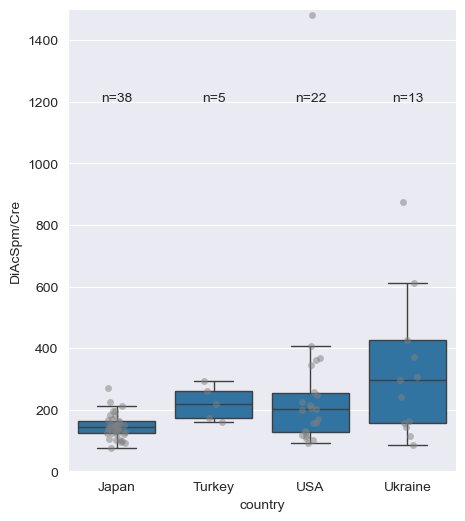

In [134]:

#健常者
df_ctr = df_merge_all_min[df_merge_all_min['class'] == 'Non-cancer']
#countryでソート
df_ctr = df_ctr.sort_values(['country'],ascending=[True])

# Plotting the boxplot and stripplot
plt.figure(figsize=(5, 6))
sns.boxplot(data=df_ctr, x='country', y='DiAcSpm/Cre',showfliers=False)
sns.stripplot(data=df_ctr, x='country', y='DiAcSpm/Cre', color='gray', alpha=0.5, dodge=True, legend=False)

#データ数を表示
for i, country in enumerate(df_ctr['country'].unique()):
    n = len(df_ctr[df_ctr['country'] == country])
    plt.text(i, 1200, f'n={n}', ha='center')
#y軸を2500にする
plt.ylim(0, 1500)
#pngで出力
plt.savefig(f"/Users/kazuyatakayama/Git/ELISA/output/{study_name}/Boxplot_country_gender_{today}.png")

In [132]:

# Filter the dataset to include only Non-cancer (healthy) individuals
non_cancer_data = df_merge_all_min[df_merge_all_min['diseaseENshort'] == 'Non-cancer']

# List of unique countries in the dataset for non-cancer individuals
countries = non_cancer_data['country'].unique()

# Calculating the median, IQR, and count for each country for 'DiAcSpm/Cre'
country_stats = non_cancer_data.groupby('country')['DiAcSpm/Cre'].agg(['median', 'count', lambda x: x.quantile(0.75) - x.quantile(0.25)]).rename(columns={'<lambda_0>': 'IQR'})

# Performing Mann-Whitney U test for each pair of countries, ensuring nonzero group sizes
mannwhitney_results = []

for i in range(len(countries)):
    for j in range(i + 1, len(countries)):
        country1 = countries[i]
        country2 = countries[j]
        group1 = non_cancer_data[non_cancer_data['country'] == country1]['DiAcSpm/Cre']
        group2 = non_cancer_data[non_cancer_data['country'] == country2]['DiAcSpm/Cre']
        
        # Ensure both groups have more than one entry
        if len(group1) > 1 and len(group2) > 1:
            u_stat, p_val = mannwhitneyu(group1, group2, alternative='two-sided')
            mannwhitney_results.append({
                'Country 1': country1,
                'Country 2': country2,
                'U Statistic': u_stat,
                'p-value': p_val,
                'Count Country 1': country_stats.loc[country1, 'count'],
                'Median Country 1': country_stats.loc[country1, 'median'],
                'IQR Country 1': country_stats.loc[country1, 'IQR'],
                'Count Country 2': country_stats.loc[country2, 'count'],
                'Median Country 2': country_stats.loc[country2, 'median'],
                'IQR Country 2': country_stats.loc[country2, 'IQR']
            })

# Converting the results to a DataFrame for better visualization
mannwhitney_df = pd.DataFrame(mannwhitney_results)

,code_clinical,diseaseENshort,DiAcSpm,creatinine,DiAcSpm/Cre,class,age,stage_L1,gender,pj,country,race,ethnicity,height,weight,collection_date
1,BIO001_21046A,Pancreas,295.790657,20.559742,1438.688590,Cancer,55,II,Female,BIO001,Ukraine,Caucasian,NaN,165.0,69.0,2019/9/20
4,BIO001_21029A,Pancreas,178.621946,34.787837,513.460911,Cancer,52,IV,Female,BIO001,Ukraine,Caucasian,NaN,158.0,64.0,2019/4/28
5,BIO001_21026A,Pancreas,69.329247,25.704244,269.719070,Cancer,71,IV,Female,BIO001,Ukraine,Caucasian,NaN,169.0,71.0,2019/4/5
6,BIO001_21023A,Pancreas,290.638554,83.563146,347.807098,Cancer,57,IV,Female,BIO001,Ukraine,Caucasian,NaN,162.0,72.0,2019/3/28
7,BIO001_21020A,Stomach,215.814786,100.236593,215.305388,Cancer,50,III,Female,BIO001,Ukraine,Caucasian,NaN,160.0,75.0,2019/4/2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,BIO001_00541A,Non-cancer,887.422342,208.308371,426.013768,Non-cancer,19,non,Female,BIO001,Ukraine,Caucasian,Turkish,165.0,48.0,2020/12/24
329,BIO001_00524A,Non-cancer,284.759459,249.664688,114.056762,Non-cancer,60,non,Female,BIO001,Ukraine,Caucasian,Turkish,173.0,81.0,2020/12/7
330,BIO001_00451A,Non-cancer,143.145173,153.675079,93.147942,Non-cancer,54,non,Male,BIO001,USA,Caucasian,NaN,180.0,79.0,2019/11/11
331,BIO001_00391A,Non-cancer,177.674007,78.950413,225.045063,Non-cancer,28,non,Female,BIO001,USA,Caucasian,NaN,160.0,59.0,2016/11/18


In [136]:
# Non-cancerデータのみを抽出
non_cancer_data = df_merge_all_min[df_merge_all_min['class'] == 'Non-cancer']

# 性別でデータを分割（男性と女性）
non_cancer_male = non_cancer_data[non_cancer_data['gender'] == 'Male']
non_cancer_female = non_cancer_data[non_cancer_data['gender'] == 'Female']

# 'DiAcSpm/Cre'変数の中央値、IQR、サンプルサイズを計算する関数
def calculate_stats(df, variable):
    median = df[variable].median()
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = f"{q1} ~ {q3}"
    sample_size = len(df[variable].dropna())
    return {'Median': median, 'IQR': iqr, 'Sample Size': sample_size}

# 'DiAcSpm/Cre'の統計値を計算
diacspm_cre_male_stats = calculate_stats(non_cancer_male, 'DiAcSpm/Cre')
diacspm_cre_female_stats = calculate_stats(non_cancer_female, 'DiAcSpm/Cre')

# Mann-Whitney Uテストで統計的有意性を評価
stat, p_value = mannwhitneyu(non_cancer_male['DiAcSpm/Cre'].dropna(), non_cancer_female['DiAcSpm/Cre'].dropna(), alternative='two-sided')

# p値を小数第4位で四捨五入
p_value_rounded = round(p_value, 4)

# 結果を1桁の小数で丸めてまとめる
results = {
    'Variable': ['DiAcSpm/Cre'],
    'Male Median (IQR)': [f"{round(diacspm_cre_male_stats['Median'], 1)} ({round(float(diacspm_cre_male_stats['IQR'].split('~')[0]), 1)} ~ {round(float(diacspm_cre_male_stats['IQR'].split('~')[1]), 1)})"],
    'Male Sample Size': [diacspm_cre_male_stats['Sample Size']],
    'Female Median (IQR)': [f"{round(diacspm_cre_female_stats['Median'], 1)} ({round(float(diacspm_cre_female_stats['IQR'].split('~')[0]), 1)} ~ {round(float(diacspm_cre_female_stats['IQR'].split('~')[1]), 1)})"],
    'Female Sample Size': [diacspm_cre_female_stats['Sample Size']],
    'p-value': [p_value_rounded]
}

# 結果をDataFrameに変換
results_df = pd.DataFrame(results)


In [137]:
results_df

,Variable,Male Median (IQR),Male Sample Size,Female Median (IQR),Female Sample Size,p-value
0,DiAcSpm/Cre,145.5 (104.5 ~ 163.0),35,195.7 (142.6 ~ 265.8),43,0.0007


In [140]:
from scipy.stats import kruskal

# ユニークな国のリストを取得
countries = non_cancer_data['country'].unique()

# 国ごとの'DiAcSpm/Cre'の中央値、IQR、サンプルサイズを計算
country_stats = {}
for country in countries:
    country_data = non_cancer_data[non_cancer_data['country'] == country]
    # 中央値とIQRを計算
    median = country_data['DiAcSpm/Cre'].median()
    q1 = country_data['DiAcSpm/Cre'].quantile(0.25)
    q3 = country_data['DiAcSpm/Cre'].quantile(0.75)
    iqr = f"{round(q1, 1)} ~ {round(q3, 1)}"
    sample_size = len(country_data['DiAcSpm/Cre'].dropna())
    country_stats[country] = {'Median': round(median, 1), 'IQR': iqr, 'Sample Size': sample_size}

# Kruskal-Wallis検定で複数グループの比較
country_values = [non_cancer_data[non_cancer_data['country'] == country]['DiAcSpm/Cre'].dropna() for country in countries]
stat, p_value_country = kruskal(*country_values)

# 国別の比較結果をDataFrameにまとめ、小数第1位で丸めて表示
country_results = {
    'Country': countries,
    'Median (IQR)': [f"{country_stats[country]['Median']} ({country_stats[country]['IQR']})" for country in countries],
    'Sample Size': [country_stats[country]['Sample Size'] for country in countries]
}

country_results_df = pd.DataFrame(country_results)
country_results_df['p-value'] = round(p_value_country, 4)  # 全体のテストのp値を追加


In [141]:
country_results_df

,Country,Median (IQR),Sample Size,p-value
0,USA,200.8 (128.1 ~ 253.8),22,0.0011
1,Japan,144.1 (125.2 ~ 161.9),38,0.0011
2,Turkey,219.5 (173.8 ~ 259.6),5,0.0011
3,Ukraine,295.7 (158.3 ~ 426.0),13,0.0011


In [23]:
#diseaseENshortのカウントする
df_merge_all_min['diseaseENshort'].value_counts()

diseaseENshort
Non-cancer    78
Pancreas      49
Stomach       45
Colorectal    31
Name: count, dtype: int64

In [21]:
#diseaseENshortがColorectalのものを抽出
df_col = df_merge_all_min[df_merge_all_min['diseaseENshort'] == 'Colorectal']

In [22]:
df_col

,code_clinical,diseaseENshort,DiAcSpm,creatinine,DiAcSpm/Cre,class,age,stage_L1,gender,pj,country,race,ethnicity,height,weight,collection_date,class_binary
419,BIO001_06330A,Colorectal,734.805138,135.599727,541.892787,Cancer,27,IV,Female,BIO001,Ukraine,Caucasian,NaN,160.0,49.0,2020/3/19,1
46,BIO001_21094A,Colorectal,1389.995586,242.960744,572.107066,Cancer,59,III,Female,BIO001,Ukraine,Caucasian,NaN,164.0,93.0,2019/3/12,1
357,BIO001_05755A,Colorectal,1175.133858,203.728239,576.814419,Cancer,80,III,Female,BIO001,Ukraine,Caucasian,NaN,160.0,83.0,2019/12/26,1
388,BIO001_06260A,Colorectal,913.949326,135.991852,672.061827,Cancer,66,II,Male,BIO001,Ukraine,Caucasian,NaN,173.0,99.0,2020/3/3,1
94,BIO001_20793A,Colorectal,440.474130,73.601361,598.459215,Cancer,68,II,Male,BIO001,Ukraine,Caucasian,NaN,176.0,72.0,2019/2/28,1
40,BIO001_21116A,Colorectal,974.192313,195.554137,498.170136,Cancer,68,IV,Female,BIO001,Ukraine,Caucasian,NaN,170.0,70.0,2019/3/11,1
41,BIO001_21102A,Colorectal,1920.757922,405.374139,473.823497,Cancer,66,II,Female,BIO001,Ukraine,Caucasian,NaN,169.0,53.0,2019/3/12,1
334,BIO001_05924A,Colorectal,586.863681,127.857481,458.998314,Cancer,59,IV,Female,BIO001,Ukraine,Caucasian,NaN,164.0,72.0,2020/1/11,1
311,BIO001_05723A,Colorectal,81.148293,18.192750,446.047416,Cancer,63,II,Male,BIO001,Ukraine,Caucasian,NaN,192.0,95.0,2020/1/13,1
340,BIO001_05802A,Colorectal,1451.140809,135.501654,1070.939556,Cancer,57,II,Female,BIO001,Ukraine,Caucasian,NaN,152.0,70.0,2020/1/28,1
